In this iPython notebook, we run **SVM**.

In [106]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Import Data</h3>

In [70]:
CELLNAME = "GM12878"
label = "p300"

In [72]:
data = pd.read_table('data/' + CELLNAME + '_features.txt.gz', compression='gzip')
data.head(2)

,chr,lower,upper,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H4K20me1,p300,eRNA,tfbs
0,1,1,200,0,0,0,0,0,0,0,0,0,0,0
1,1,201,400,0,0,0,0,0,0,0,0,0,0,0


In [90]:
feature_names = list(data.columns.values)
feature_names = feature_names[3:]
feature_names.remove(label)
print feature_names

['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1', 'eRNA', 'tfbs']


In [91]:
print data[label].value_counts()

0    14291273
1      113883
dtype: int64


In [92]:
#Select positive set
positive = data[data[label]==1]
nrows = positive.shape[0]
print positive.shape

#Select negative set
use_random_sampling = False 
if use_random_sampling:
    negative = data[data[label]==0].as_matrix()
    nrows = negative.shape[0]
    select = np.random.choice(nrows, positive.shape[0]) # same size as positive set
    negative = negative[select,:]
    print negative.shape
else: # follow distribution of positive set
    indices = data[data[label]==1].index.values
    diff = np.diff(indices)
    offset = np.floor(np.mean(np.diff(indices))/2)
    select = (indices)+offset.astype(np.int64)
    mean_distance = np.mean(np.diff(indices))*200 # approximate value
    negative = data.iloc[select]
    negative = negative[negative[label]==0]
    print negative.shape

#Form sample
sample = pd.concat([positive,negative])
print sample.shape

(113883, 14)
(107085, 14)
(220968, 14)


In [93]:
X = sample.drop(['chr','lower','upper',label], axis=1).as_matrix()
print X

[[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]]


In [94]:
y = sample[label].as_matrix()
print y

[1 1 1 ..., 0 0 0]


Correlation coefficient matrix among features

In [95]:
ccoef = np.corrcoef(X, rowvar=0)
i=1
for k in ccoef:
    print np.around(k[:i], decimals=2)
    i=i+1

[ 1.]
[ 0.  1.]
[ 0.02  0.28  1.  ]
[ 0.55  0.03  0.06  1.  ]
[ 0.7  -0.   -0.01  0.57  1.  ]
[ 0.59  0.19  0.14  0.38  0.63  1.  ]
[ 0.69  0.07  0.04  0.39  0.64  0.62  1.  ]
[ 0.05  0.43  0.33  0.09  0.05  0.2   0.11  1.  ]
[ 0.3  -0.03 -0.04  0.19  0.29  0.22  0.28 -0.02  1.  ]
[ 0.13 -0.03  0.    0.09  0.16  0.1   0.13 -0.03  0.08  1.  ]


<h3>Run SVM</h3>

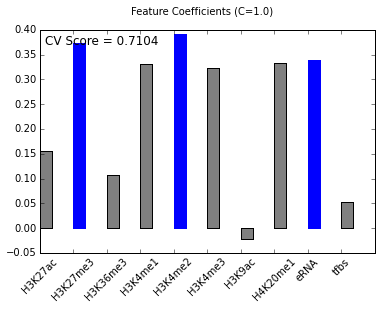

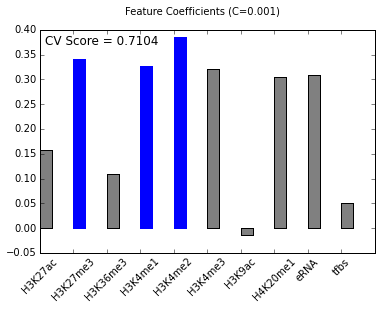

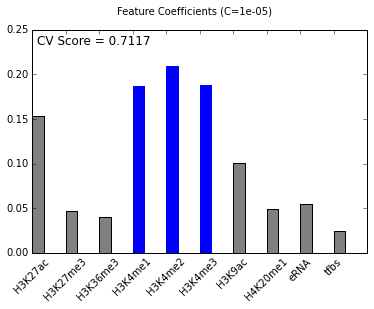

In [102]:
regs = [1.0, 0.001, 0.00001]
for reg in regs: 
    clf = svm.LinearSVC(C=reg) 
    clf.fit(X,y)
    
    # 10-fold cross-validation
    scores = cross_validation.cross_val_score(clf, X, y, cv=10)
    mean_cv = sum(scores) / float(len(scores))

    coef = clf.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:3]

    # Plot
    fig, ax = plt.subplots()
    ind = np.arange(len(feature_names))  
    width = 0.35  
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top_coef:
        rects[index].set_color('b')
    plt.xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names,rotation=45)
    ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                xytext=(5, -5), textcoords='offset points',
                ha='left', va='top')
    plt.suptitle("Feature Coefficients (C=%s)" %reg)
    plt.show()

<u>Misclassified Counts</u>

In [103]:
def print_counts(counts):
    print "# Misclassified in Positive Set: %d" %c[(0,1)]
    print "# Misclassified in Negative Set: %d" %c[(1,0)]

In [104]:
from collections import Counter
# K-fold cross-validation
cv = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
clf = svm.LinearSVC()

scores = []
results = []
for train_index, test_index in cv:
    clf.fit(X[train_index], y[train_index])
    coef = clf.coef_
    pred = clf.predict(X[test_index])
    counts = Counter(zip(pred, y[test_index]))
    results.append(counts)
    scores.append(clf.score(X[test_index], y[test_index]))

print "Cross-validation Scores"
print scores

print "\nMisclassified Counts for Each Fold"
for c in results:
    print "-"
    print_counts(c)

Cross-validation Scores
[0.71181608363126214, 0.71163506358329187, 0.70987011811558132, 0.707827031430317, 0.711538026384269]

Misclassified Counts for Each Fold
-
# Misclassified in Positive Set: 9258
# Misclassified in Negative Set: 3478
-
# Misclassified in Positive Set: 9180
# Misclassified in Negative Set: 3564
-
# Misclassified in Positive Set: 9304
# Misclassified in Negative Set: 3518
-
# Misclassified in Positive Set: 9286
# Misclassified in Negative Set: 3626
-
# Misclassified in Positive Set: 9212
# Misclassified in Negative Set: 3536


<h3>Run SVM after PCA</h3>

In [107]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
print "Explained Variance Ratio"
print(pca.explained_variance_ratio_) 
cp = pca.components_

# Plot the linear combinations
show_plots = True
if show_plots:
    ind = np.arange(9)  
    width = 0.35  
    feature_names = data.columns.values
    feature_names = feature_names[:9]
    i=1
    for comb in cp:
         ax = plt.subplot()
         ax.bar(ind, comb, width, color='slateblue')
         ax.set_xticklabels(feature_names,rotation=45)
         plt.title('Component %d' %i)
         plt.show()
         i = i+1

Explained Variance Ratio
[ 0.48904685  0.12479439  0.10430215  0.07933745  0.05208889]


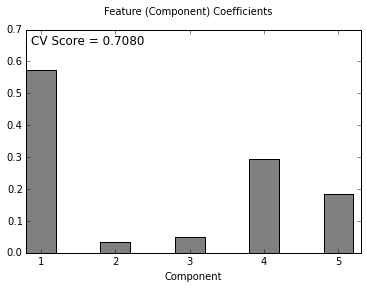

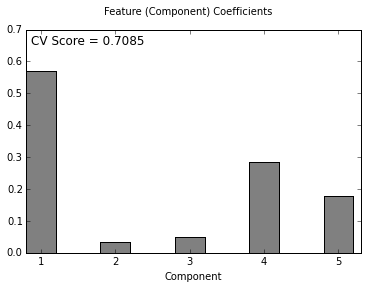

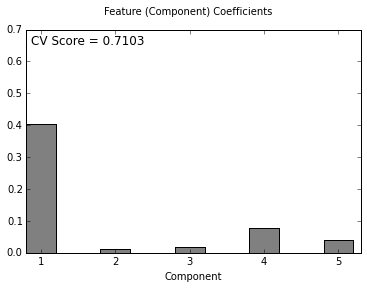

In [108]:
regs = [1.0, 0.001, 0.00001, 0.000001]
for reg in regs: 
    clf = svm.LinearSVC(C=reg) 
    clf.fit(X_pca,y)
    
    # 10-fold cross-validation
    scores = cross_validation.cross_val_score(clf, X_pca, y, cv=10)
    mean_cv = sum(scores) / float(len(scores))

    coef = clf.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:3]

    # Plot
    ax = plt.subplot()
    ind = np.arange(5) 
    width = 0.4  
    rects = ax.bar(ind, np.abs(coef), width, color='gray')
    plt.xticks(np.arange(5)+0.2)
    ax.set_xticklabels(['1','2','3','4','5'])
    plt.suptitle("Feature (Component) Coefficients (C=%s)" %reg)
    plt.xlabel("Component")
    ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                        xytext=(5, -5), textcoords='offset points',
                        ha='left', va='top')
    plt.ylim(0, 0.7)
    plt.show()

<h3>Run Logistic Regression</h3>
with L1 and L2 penalty

L1 penalty

In [31]:
from sklearn import linear_model
from sklearn import cross_validation
logreg = linear_model.LogisticRegression(penalty='l1')
logreg.fit(X,y)
print cross_validation.cross_val_score(logreg, X, y, cv=10)

[ 0.7259028   0.71020002  0.71671644  0.71543648  0.70778839  0.72995112
  0.69510319  0.69845221  0.7112147   0.69523896]


[0.38727166617776415, 0.85497772687939932, 0.25372190903794417, 0.80513283100907951, 0.92000653675462596, 0.90723554259955286, -0.014911816541343922, 0.86835968206882419, 1.2209074550547834]


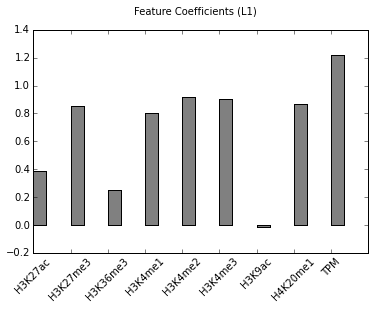

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
coef = logreg.coef_
coef = [item for sublist in coef for item in sublist] #flatten list

print coef
feature_names = data.columns.values
feature_names = feature_names[:9]
#print zip(feature_names, coef)

ind = np.arange(9)  
width = 0.35       

fig, ax = plt.subplots()
rects = ax.bar(ind, coef, width, color='gray')
ax.set_xticklabels(feature_names,rotation=45)
plt.suptitle("Feature Coefficients (L1)")
plt.show()

L2 penalty

0.71060043056


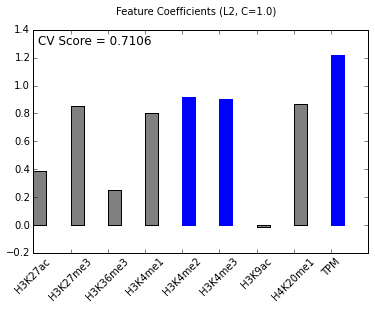

0.710604957086


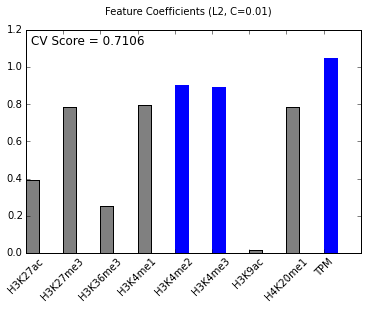

0.711179694305


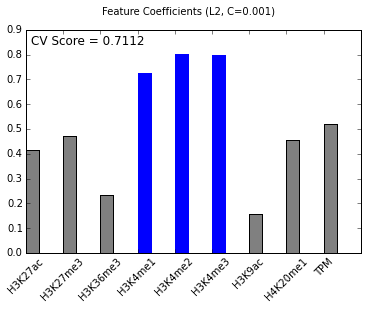

0.711763489081


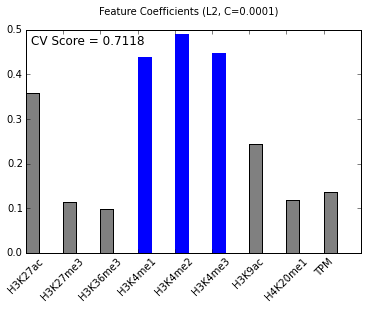

0.713347437441


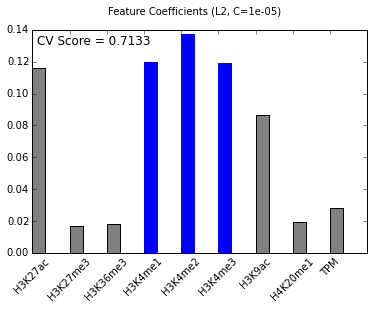

0.707857980106


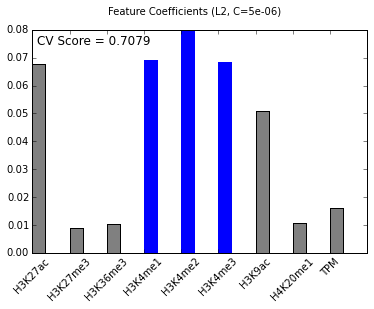

0.515382317867


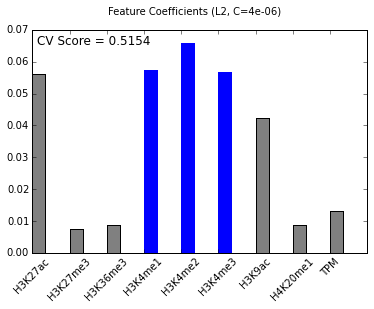

In [14]:
from sklearn import linear_model
from sklearn import cross_validation
regs = [1.0, 0.01, 0.001, 0.0001, 0.00001, 0.000005, 0.000004]
for reg in regs: 
    logreg2 = linear_model.LogisticRegression(penalty='l2', C=reg)
    logreg2.fit(X,y)
    scores = cross_validation.cross_val_score(logreg2, X, y, cv=10)
    cv = sum(scores) / float(len(scores))
    print cv

    import matplotlib.pyplot as plt
    %matplotlib inline
    coef = logreg2.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list

    #print coef
    feature_names = data.columns.values
    feature_names = feature_names[:9]
    #print zip(feature_names, coef)

    ind = np.arange(9)  
    width = 0.35       

    coef_np = np.asarray(coef)
    top3 = np.argsort(-coef_np)[:3]

    fig, ax = plt.subplots()
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top3:
        rects[index].set_color('b')
    ax.set_xticklabels(feature_names,rotation=45)
    plt.suptitle("Feature Coefficients (L2, C=%s)" %reg)
    ax.annotate('CV Score = %0.4f'%cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
    plt.show()